In [1]:
import datetime, random 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import PReLU
import matplotlib.pyplot as plt 

2023-12-08 14:29:21.903886: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 14:29:21.905435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 14:29:21.939357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 14:29:21.940088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 14:29:22.489744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Setting Var

In [2]:
visited_color = 0.8 
agent_color = 0.5

# action possible in maze
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

actions_dict = {
    LEFT : 'left',
    UP : 'up',
    RIGHT : 'right',
    DOWN : 'down'
}

num_actions = len(actions_dict)

# Esploration
epsilon = 0.1 

### Class Qmaze Implementation for a Maze

In [3]:
import numpy as np

LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

agent_color = 0.5

class Qmaze(object):
    def __init__(self, maze, agent=(0, 0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows - 1, ncols - 1)
        self.free_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception('Labirinto non valido: la destinazione non può essere un muro!')
        if not agent in self.free_cells:
            raise Exception("Posizione agente non valida: l'agente deve essere posizionato su una cella libera")
        self.reset(agent)

    def reset(self, agent):
        self.agent = agent
        self.maze = np.copy(self._maze)
        row, col = agent
        self.maze[row, col] = agent_color
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        agent_row, agent_col, mode = self.state

        if self.maze[agent_row, agent_col] > 0.0:
            self.visited.add((agent_row, agent_col))

        valid_actions = self.valid_actions()

        if not valid_actions:
            mode = 'blocked'
        elif action in valid_actions:
            mode = 'valid'
            if action == LEFT:
                agent_col -= 1
            elif action == UP:
                agent_row -= 1
            elif action == RIGHT:
                agent_col += 1
            elif action == DOWN:
                agent_row += 1
        else:
            mode = 'invalid'

        self.state = (agent_row, agent_col, mode)

    def get_reward(self):
        agent_row, agent_col, mode = self.state
        nrows, ncols = self.maze.shape
        if agent_row == nrows - 1 and agent_col == ncols - 1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (agent_row, agent_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        return self.observe(), reward, self.game_status()

    def observe(self):
        canvas = np.copy(self.maze)
        row, col, _ = self.state
        canvas[row, col] = 0.5 
        return canvas.flatten()

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r, c] > 0.0:
                    canvas[r, c] = 1.0

        agent_row, agent_col, _ = self.state
        canvas[agent_row, agent_col] = agent_color
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        agent_row, agent_col, _ = self.state
        nrows, ncols = self.maze.shape
        if agent_row == nrows - 1 and agent_col == ncols - 1:
            return 'win'
        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            agent_row, agent_col, _ = self.state
        else:
            agent_row, agent_col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if agent_row == 0:
            actions.remove(1)
        elif agent_row == nrows - 1:
            actions.remove(3)

        if agent_col == 0:
            actions.remove(0)
        elif agent_col == ncols - 1:
            actions.remove(2)

        if agent_row > 0 and self.maze[agent_row - 1, agent_col] == 0.0:
            actions.remove(1)
        if agent_row < nrows - 1 and self.maze[agent_row + 1, agent_col] == 0.0:
            actions.remove(3)

        if agent_col > 0 and self.maze[agent_row, agent_col - 1] == 0.0:
            actions.remove(0)

        if agent_col < ncols - 1 and self.maze[agent_row, agent_col + 1] == 0.0:
            actions.remove(2)

        return actions


### Illustratio ma

In [4]:
def show(qmaze):
    plt.grid(True)
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    canvas = np.copy(qmaze.maze)
    for row, col in qmaze.visited:
        canvas[row, col] = visited_color
    agent_row, agent_col, _ = qmaze.state
    canvas[agent_row, agent_col] = agent_color
    canvas[nrows -1, ncols -1] = 0.9
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    plt.show()
    return img

### maze creation and illustration

reward =  -0.04


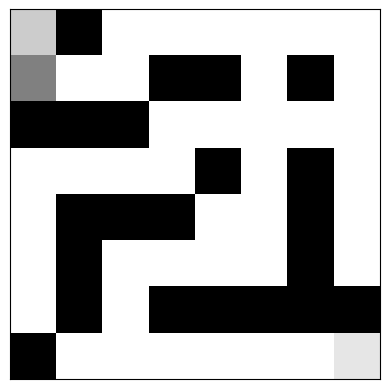

In [5]:
maze = np.array([
    [1.,0.,1.,1.,1.,1.,1.,1.],
    [1.,1.,1.,0.,0.,1.,0.,1.],
    [0.,0.,0.,1.,1.,1.,1.,1.],
    [1.,1.,1.,1.,0.,1.,0.,1.],
    [1.,0.,0.,0.,1.,1.,0.,1.],
    [1.,0.,1.,1.,1.,1.,0.,1.],
    [1.,0.,1.,0.,0.,0.,0.,0.],
    [0.,1.,1.,1.,1.,1.,1.,1.]])

qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward = ", reward)
show(qmaze)

### move in the maze

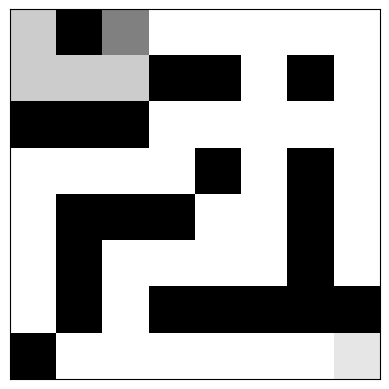

In [6]:
qmaze.act(DOWN)
qmaze.act(RIGHT)
qmaze.act(RIGHT)
qmaze.act(RIGHT)
qmaze.act(UP)
show(qmaze)

### simulation of a game

In [7]:
def play_game(model, qmaze, agent_cell):
    qmaze.reset(agent_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        q = model.test_models(prev_envstate)
        action = np.argmax(q)

        envstate, reward, gamer_status = qmaze.act(action)
        if game_status == 'win':
            return True

        elif game_status == 'lose':
            return False

### Check if it is possible to simulate inside the maze.

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True
    

### Implement sequential memory where it collects the agent's experience to train the model itself

In [9]:
class Experience(object):
    def __init__(self, input_shape, output_shape, batch_size=32, memory_limit=1000):
        self.batch_size = batch_size
        self.memory_limit = memory_limit

        self.states_memory = np.zeros((self.memory_limit, input_shape), dtype=np.float16)
        self.outputs_memory = np.zeros((self.memory_limit, output_shape), dtype=np.float16)

        self.inputs = np.zeros((self.batch_size, input_shape))
        self.targets = np.zeros((self.batch_size, output_shape))
        self.memory_index = 0
        self.memory_ready = False
        self.batches_number = int((self.memory_limit / self.batch_size) / 4)

    def add_to_memory(self, state, output):
        self.states_memory[self.memory_index] = state
        self.outputs_memory[self.memory_index] = output
        self.memory_index += 1
        if self.memory_index  >= self.memory_limit:
            self.memory_index = 0
            self.memory_ready = True

    def get_random_batches(self, ):
        for i, j in enumerate(np.random.choice(range(self.memory_limit), self.batch_size, replace=False)):
            self.inputs[i] = self.states_memory[j]
            self.targets[i] = self.outputs_memory[j]
        return self.inputs, self.targets

### Model definition

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, PReLU

class Model():
    def __init__(
        self,
        batch_size,
        input_shape,
        output_shape,
        cells=64,
    ):
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.input_shape = input_shape
        self.output_shape = output_shape

        self.model_play = self.get_model(
            batch_size=1,
            state_number=self.input_shape,
            cells=cells,
            optimizer=self.optimizer,
            loss_fn=self.loss_fn,
            n_output=self.output_shape)
        self.model_play.summary() 

        self.model_train = self.get_model(
            batch_size=batch_size,
            state_number=self.input_shape,
            cells=cells,
            optimizer=self.optimizer,
            loss_fn=self.loss_fn,
            n_output=self.output_shape)

    def get_model(self, batch_size=32, state_number=1, cells=32, optimizer=None, loss_fn=None, n_output=4):
        input_state = tf.keras.layers.Input(batch_size=batch_size, shape=state_number, name="InputState")

        dense = Dense(cells)(input_state)
        dense = PReLU()(dense)
        dense = Dense(cells * 2)(dense)
        dense = PReLU()(dense)
        out = Dense(n_output)(dense)  

        model = tf.keras.Model(
            inputs=[input_state],
            outputs=[out])

        model.compile(
            optimizer=optimizer,
            loss=loss_fn)
        
        return model
        
    @tf.function(jit_compile=True)
    def train_step(self, state, y):
        with tf.GradientTape() as tape:
            results = self.model_train(state, training=True)
            loss_value = self.loss_fn(y, results)
        grads = tape.gradient(loss_value, self.model_train.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model_train.trainable_weights))
        return loss_value

    @tf.function(jit_compile=True)
    def test_models(self, nets_inputs):
        action_1 = self.model_play(nets_inputs, training=False)[0]
        return action_1

    def swap_nets(self):
        self.model_play.set_weights(self.model_train.get_weights())

    def load_weights(self, path):
        self.model_play.load_weights(path)
        self.model_train.load_weights(path)

            

### qtrain allows performing a training loop

In [11]:
def qtrain(model, maze, epochs=1000, max_memory=1000, batch=32, gamma=0.95, exploration=0.1, name='model'):
    start_time = datetime.datetime.now()
    qmaze = Qmaze(maze)
    experience = Experience(input_shape=model.input_shape, output_shape=model.output_shape, batch_size=batch, memory_limit=1000)

    win_history = []
    hsize = qmaze.maze.size // 2
    win_rate = 0.0
    losses = []

    batches = int(experience.memory_limit / experience.batch_size)

    for epoch in range(epochs):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False
        envstate = qmaze.observe()

        n_episodes = 0

        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break
            prev_envstate = envstate
            
            tensor_actions = model.test_models(tf.convert_to_tensor([prev_envstate]))
            actions = tf.keras.backend.get_value(tensor_actions)
            if np.random.rand() < exploration:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(tensor_actions)

            envstate, reward, game_status = qmaze.act(action)

            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            tensor_next_actions = model.test_models(tf.convert_to_tensor([envstate]))
            if game_over:
                actions[action] = reward
            else:
                Q_sa = np.max(tensor_next_actions)
                actions[action] = reward + gamma * Q_sa


            experience.add_to_memory(prev_envstate, actions)
            n_episodes += 1

            if experience.memory_ready:
                for _ in range(experience.batches_number):
                    state, y = experience.get_random_batches()
                    loss = model.train_step(state, y)
                    losses.append(loss)
                model.swap_nets()

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        print(template.format(epoch, epochs - 1, loss, n_episodes, sum(win_history), win_rate, t))

        if win_rate > 0.9:
            exploration = 0.05
        if sum(win_history[-hsize:]) == hsize:
            print("Reached 100%% win rate at epoch: %s" % (epoch,))
            break

    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("n_epoch: %d, max_mem: %d, batch: %d, time: %s" % (epoch, max_memory, batch, t))
    return seconds

def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%2.f minutes" % (m, )
    else:
        h = seconds / 3600.0
        return "%2.f hours" % (h, )

### Train model

In [12]:
model = Model(batch_size=32, input_shape=maze.size, output_shape=len(actions_dict), )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputState (InputLayer)     [(1, 64)]                 0         
                                                                 
 dense (Dense)               (1, 64)                   4160      
                                                                 
 p_re_lu (PReLU)             (1, 64)                   64        
                                                                 
 dense_1 (Dense)             (1, 128)                  8320      
                                                                 
 p_re_lu_1 (PReLU)           (1, 128)                  128       
                                                                 
 dense_2 (Dense)             (1, 4)                    516       
                                                                 
Total params: 13188 (51.52 KB)
Trainable params: 13188 (51.52

In [13]:
qtrain(model, maze, epochs=500, max_memory=4 * maze.size, batch=32)

2023-12-08 14:29:23.976143: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562ffc93a730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-08 14:29:23.976164: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-08 14:29:23.980373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-08 14:29:24.028059: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 000/499 | Loss: 0.0000 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 0.2 seconds
Epoch: 001/499 | Loss: 0.0000 | Episodes: 136 | Win count: 0 | Win rate: 0.000 | Time: 0.4 seconds
Epoch: 002/499 | Loss: 0.0000 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | Time: 0.5 seconds
Epoch: 003/499 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | Time: 0.7 seconds
Epoch: 004/499 | Loss: 0.0000 | Episodes: 8 | Win count: 1 | Win rate: 0.000 | Time: 0.7 seconds
Epoch: 005/499 | Loss: 0.0000 | Episodes: 136 | Win count: 1 | Win rate: 0.000 | Time: 0.8 seconds
Epoch: 006/499 | Loss: 0.0000 | Episodes: 133 | Win count: 1 | Win rate: 0.000 | Time: 0.9 seconds
Epoch: 007/499 | Loss: 0.0000 | Episodes: 133 | Win count: 1 | Win rate: 0.000 | Time: 1.1 seconds
Epoch: 008/499 | Loss: 0.0115 | Episodes: 139 | Win count: 1 | Win rate: 0.000 | Time: 2.5 seconds
Epoch: 009/499 | Loss: 0.0102 | Episodes: 131 | Win count: 1 | Win rate: 0.000 | Time: 3.5 seconds
Epoch: 010/4

203.382598

### Deploy the agent in the generated environment to leverage the 'show' method at each individual step

In [14]:
def play_game_show(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        q = model.test_models(np.expand_dims(prev_envstate, axis=0))

        action = np.argmax(q)
        envstate, reward, game_status = qmaze.act(action)
        print(actions_dict[action])
        show(qmaze)
        if game_status == 'win':
            return game_status
        elif game_status == 'lose':
            return game_status
        

left


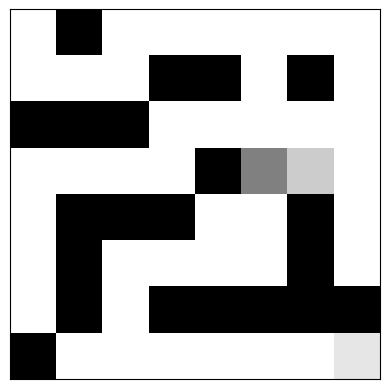

down


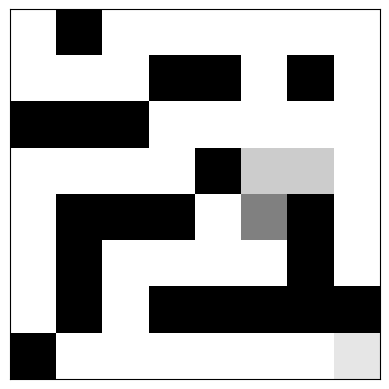

down


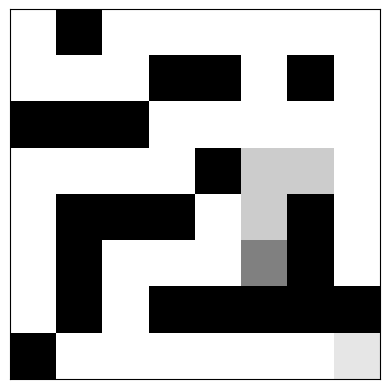

left


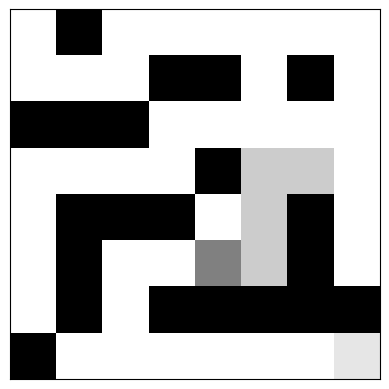

left


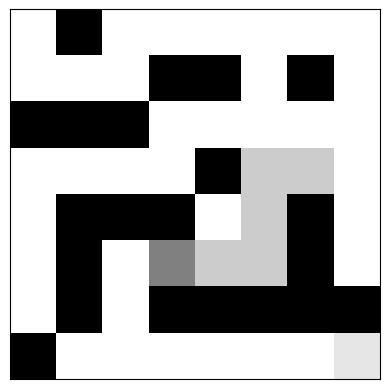

left


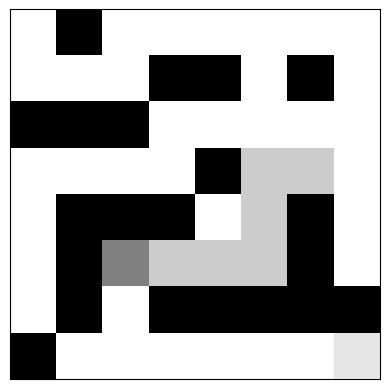

down


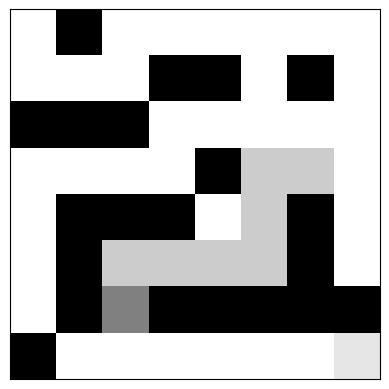

down


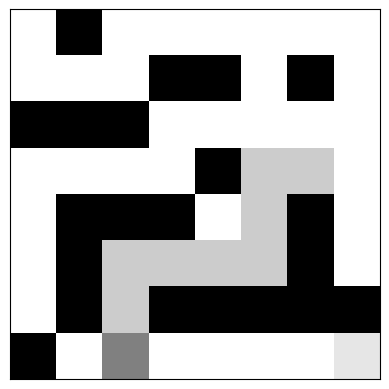

right


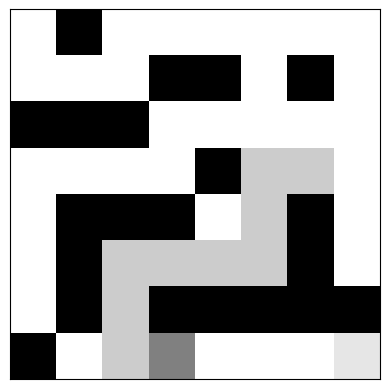

right


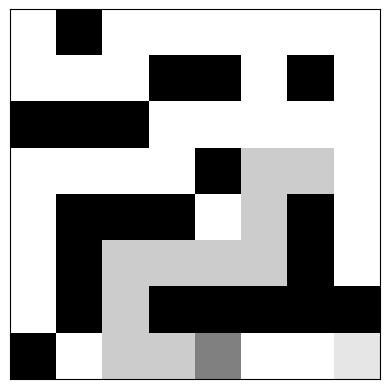

right


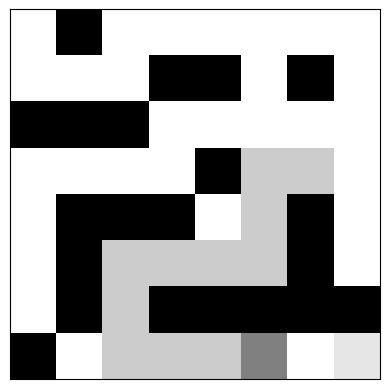

right


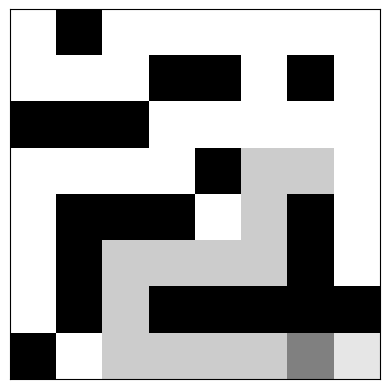

right


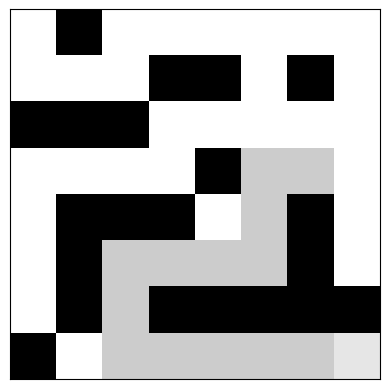

'win'

In [18]:
play_game_show(model, qmaze, (3, 6))